# MarlimR3D - Comparison

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

## Figure 4 from Correa and Menezes (2019), but noise-free data

In [3]:
def print_attributes(inp):
    """Print info from modeller."""
    for key in ['runtime', 'n_procs', 'max_ram',
                'n_cells', 'n_nodes', 'n_dof', 'extent',
                'min_vol', 'max_vol', 'machine',
                'version', 'date']:
        print(f"{key:10} : {inp.attrs[key]}")

In [4]:
data = xr.load_dataset('marlim_data.nc', engine='h5netcdf')
egd = xr.load_dataset('results/marlim_emg3d.nc', engine='h5netcdf')
cst = xr.load_dataset('results/marlim_custEM_p2.nc', engine='h5netcdf')
ptg = xr.load_dataset('results/marlim_petgem.nc', engine='h5netcdf')
spg = xr.load_dataset('results/marlim_simpeg.nc', engine='h5netcdf')

for dat, name in zip([egd, cst, ptg, spg], ['emg3d', 'custEM', 'PETGEM', 'SimPEG']):
    print(f"\n= - = - =  : {name} {14*'= - '}=\n")
    print_attributes(dat)


= - = - =  : emg3d = - = - = - = - = - = - = - = - = - = - = - = - = - = - =

runtime    : 1200 s
n_procs    : 1
max_ram    : 0.546 GiB
n_cells    : (192 x 80 x 128) - 1966080
n_nodes    : N/A
n_dof      : 5998992
extent     : x = 327426.0-453624.0; y = 7464458.2-7570039.8; z = -56648.0-83814.0
min_vol    : 200000.0
max_vol    : 7961665640795.1
machine    : Laptop; i7-6600U CPU@2.6 GHz x4; 15.5 GiB of memory, Ubuntu 18.04
version    : emg3d v0.12.0
date       : 2020-09-11T08:59:22.925996

= - = - =  : custEM = - = - = - = - = - = - = - = - = - = - = - = - = - = - =

runtime    : 4984 s
n_procs    : 64
max_ram    : 558.5 GiB
n_cells    : 710625
n_nodes    : 118399
n_dof      : 9078948
extent     : x = -22800 - 22800; y = -22800 - 22800; z = -22800 - 22800
min_vol    : N/A
max_vol    : N/A
machine    : PowerEdge R940 server; 144 Xeon Gold 6154 CPU @2.666 GHz; ~3 TB DDR4 RAM; Ubuntu 18.04
version    : custEM v0.99.05
date       : 2020-04-03T13:14:24.066044

= - = - =  : PETGEM = - = - = 

In [5]:
# Receiver positions (reciprocity)
offs = egd.src_x[::2] - egd.rec_x

# Line styles
ls = ['co', 'ys', 'm*', 'gd', 'rv', 'b^']

def extract_line(d, n, b=None):
    data = getattr(d, n)
    data = abs(data.data[::2, :, :] + 1j*data.data[1::2, :, :])
    
    if b is not None:
        comp = getattr(b, n)
        comp = abs(comp.data[::2, :, :] + 1j*comp.data[1::2, :, :])
        
        data -= comp

    return data

<IPython.core.display.Javascript object>


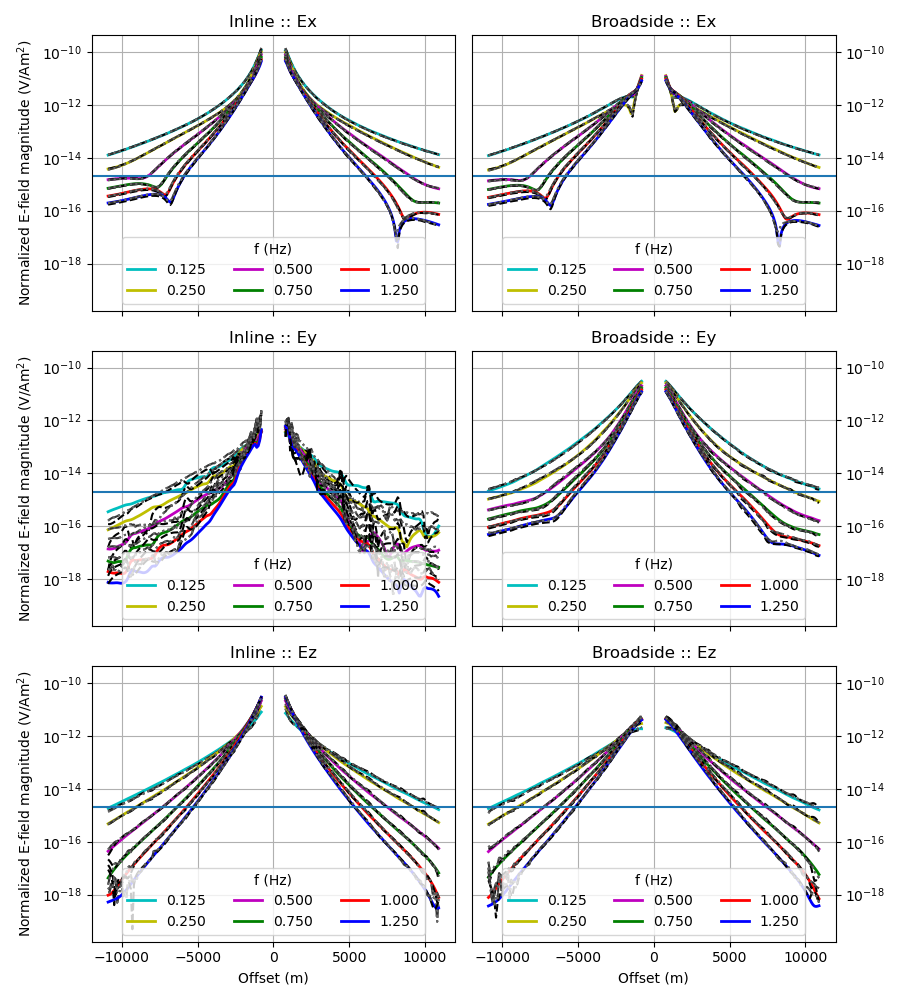

In [6]:
fig, axs = plt.subplots(3, 2, figsize=(9, 10), sharex=True, sharey=True)

# Loop over Inline/Broadside
for iii, datname in enumerate(['data_il', 'data_bs']):

    # Get absolute values of this line
    tdat = extract_line(data, datname)
    tegd = extract_line(egd, datname)
    tcst = extract_line(cst, datname)
    tptg = extract_line(ptg, datname)

    # Loop over components Ex, Ey, Ez
    for ii, comp in enumerate(data.components.values[:3]):

        plt.sca(axs[ii, iii])
        plt.title(f"{['Inline', 'Broadside'][iii]} :: {comp}")

        # Loop over frequencies
        for i, freq in enumerate(data.freqs.values):

            # Plot this component/frequency
            plt.plot(offs[:102], tdat[:102, i, ii], ls[i][0]+'-', lw=2, label=f"{freq:4.3f}")
            plt.plot(offs[102:], tdat[102:, i, ii], ls[i][0]+'-', lw=2)
            plt.plot(offs[:102], tegd[:102, i, ii], 'k--')
            plt.plot(offs[102:], tegd[102:, i, ii], 'k--')
            plt.plot(offs[:102], tcst[:102, i, ii], '-.', c='.2')
            plt.plot(offs[102:], tcst[102:, i, ii], '-.', c='.2')
            plt.plot(offs[:102], tptg[:102, i, ii], ':', c='.4')
            plt.plot(offs[102:], tptg[102:, i, ii], ':', c='.4')      

        plt.axhline(2e-15)
        plt.legend(title='f (Hz)', loc='lower center', ncol=3)
        plt.grid('on')
        plt.yscale('log')
        
        if ii == 2:
            plt.xlabel('Offset (m)')
        if iii == 0:
            plt.ylabel('Normalized E-field magnitude (V/Am$^2$)')
        else:
            axs[ii, iii].yaxis.set_ticks_position('right')
            axs[ii, iii].yaxis.set_label_position('right')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


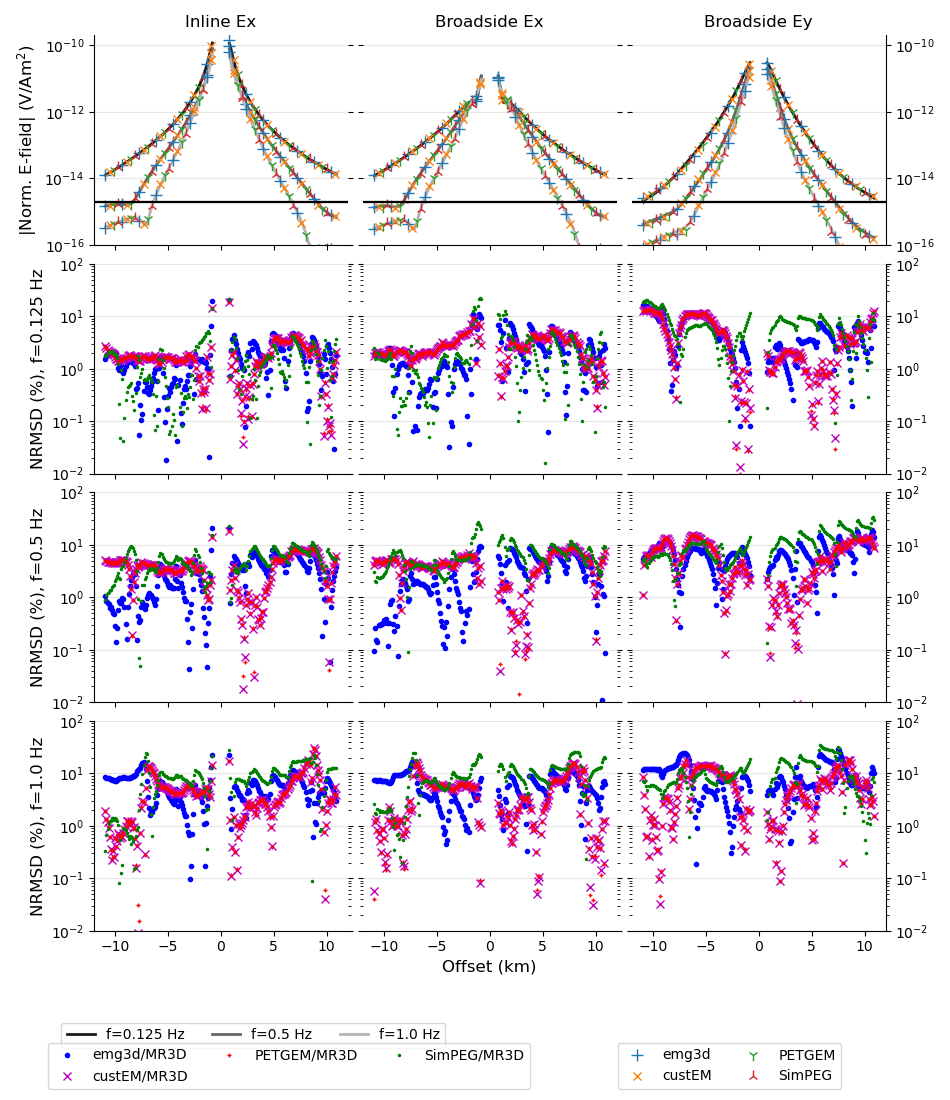

In [7]:
fs = 12
fig, axs = plt.subplots(4, 3, figsize=(9.5, 11), sharex=True)

ls = ['-', ':', '--']
ms = 8

# Loop over Inline/Broadside
for iii, datname in enumerate(['data_il', 'data_bs']):

    # Get absolute values of this line
    tdat = extract_line(data, datname)
    tegd = extract_line(egd, datname)
    tcst = extract_line(cst, datname)
    tptg = extract_line(ptg, datname)
    tspg = extract_line(spg, datname)

    # Loop over components Ex, Ey, Ez
    if datname == 'data_il':
        values = data.components.values[:1]  # Ex
    else:
        values = data.components.values[:2]  # Ex, Ey
        
    # Loop over frequencies
    for i, freq in enumerate(data.freqs.values[::2]):  # every 2nd
        
        # Fields
        for ii, comp in enumerate(values):

            plt.sca(axs[0, ii+iii])
            plt.title(f"{['Inline', 'Broadside'][iii]} {comp}")


            # Plot this component/frequency
            plt.plot(offs[:102]/1e3, tdat[:102, i*2, ii], str(.1+i*.3), lw=2,
                     label=f"f={freq} Hz" if ii+iii == 0 else None)
            plt.plot(offs[102:]/1e3, tdat[102:, i*2, ii], str(.1+i*.3), lw=2)
            
            plt.plot(offs[:102:16]/1e3, tegd[:102:16, i*2, ii], 'C0', ls="", marker="+", ms=ms,
                     label=f"emg3d" if (i == 0 and ii+iii == 1) else None)
            plt.plot(offs[102::16]/1e3, tegd[102::16, i*2, ii], 'C0', ls="", marker="+", ms=ms)
            
            plt.plot(offs[4:102:16]/1e3, tcst[4:102:16, i*2, ii], 'C1', ls="", marker="x", ms=ms-2)
            plt.plot(offs[106::16]/1e3, tcst[106::16, i*2, ii], 'C1', ls="", marker="x", ms=ms-2,
                     label=f"custEM" if (i == 0 and ii+iii == 1) else None)
            
            plt.plot(offs[8:102:16]/1e3, tptg[8:102:16, i*2, ii], 'C2', ls="", marker="1", ms=ms)
            plt.plot(offs[110::16]/1e3, tptg[110::16, i*2, ii], 'C2', ls="", marker="1", ms=ms,
                     label=f"PETGEM" if (i == 0 and ii+iii == 1) else None)
            
            plt.plot(offs[12:102:16]/1e3, tspg[12:102:16, i*2, ii], 'C3', ls="", marker="2", ms=ms)
            plt.plot(offs[114::16]/1e3, tspg[114::16, i*2, ii], 'C3', ls="", marker="2", ms=ms,
                     label=f"SimPEG" if (i == 0 and ii+iii == 1) else None)

            plt.axhline(2e-15, c='k')           
    
            plt.grid(axis='y', c='0.9')
            plt.yscale('log')
            plt.ylim([1e-16, 2e-10])
            if ii+iii == 2:
                axs[0, 2].yaxis.tick_right()
            axs[0, ii+iii].yaxis.set_ticks_position('both')

        axs[0, 0].set_ylabel('|Norm. E-field| (V/Am$^2$)', fontsize=fs)
        axs[0, 1].set_yticklabels(())

        # Error
        for ii, comp in enumerate(values):

            plt.sca(axs[1+i, ii+iii])

            # Plot difference
            dat_egd = 200*abs(tdat[:, i*2, ii]-tegd[:, i*2, ii])/(abs(tdat[:, i*2, ii])+abs(tegd[:, i*2, ii]))
            dat_cst = 200*abs(tdat[:, i*2, ii]-tcst[:, i*2, ii])/(abs(tdat[:, i*2, ii])+abs(tcst[:, i*2, ii]))
            dat_ptg = 200*abs(tdat[:, i*2, ii]-tptg[:, i*2, ii])/(abs(tdat[:, i*2, ii])+abs(tptg[:, i*2, ii]))
            dat_spg = 200*abs(tdat[:, i*2, ii]-tspg[:, i*2, ii])/(abs(tdat[:, i*2, ii])+abs(tspg[:, i*2, ii]))
            
            plt.plot(offs/1e3, dat_egd, 'b.', label="emg3d/MR3D" if i == 0 else None)
            plt.plot(offs/1e3, dat_cst, 'mx', label="custEM/MR3D" if i == 0 else None)
            plt.plot(offs/1e3, dat_ptg, 'r+', ms=3, label="PETGEM/MR3D" if i == 0 else None)
            plt.plot(offs/1e3, dat_spg, 'g.', ms=3, label="SimPEG/MR3D" if i == 0 else None)
            
            plt.grid(axis='y', c='0.9')
            plt.yscale('log')
            plt.ylim([1e-2, 1e2])
            if ii+iii == 2:
                axs[1+i, 2].yaxis.tick_right()
            axs[1+i, ii+iii].yaxis.set_ticks_position('both')

        axs[1+i, 0].set_ylabel(f'NRMSD (%), f={freq} Hz', fontsize=fs)
        axs[1+i, 1].set_yticklabels(())

    axs[3, 1].set_xlabel('Offset (km)', fontsize=fs)


# Switch off spines
for i in range(4):
    for ii in range(3):
        axs[i, ii].spines['top'].set_visible(False)
    for ii in range(2):
        axs[i, ii].spines['right'].set_visible(False)
    for ii in range(1, 3):
        axs[i, ii].spines['left'].set_visible(False)
        
plt.tight_layout(h_pad=0.02, rect=[0, 0.1, 1, 1])

plt.sca(axs[0, 1])
plt.legend(bbox_to_anchor=(0.65, 0.01), bbox_transform=fig.transFigure,
           loc='lower left', borderaxespad=0., ncol=2)  
plt.sca(axs[0, 0])
plt.legend(bbox_to_anchor=(0.05, 0.035), bbox_transform=fig.transFigure,
           loc='lower left', borderaxespad=1., ncol=3)  

plt.sca(axs[1, 0])
plt.legend(bbox_to_anchor=(0.05, 0.01), bbox_transform=fig.transFigure,
           loc='lower left', borderaxespad=0., ncol=3)  
                
#plt.savefig(f'../manuscript/figures/results-marlim_2.pdf', bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


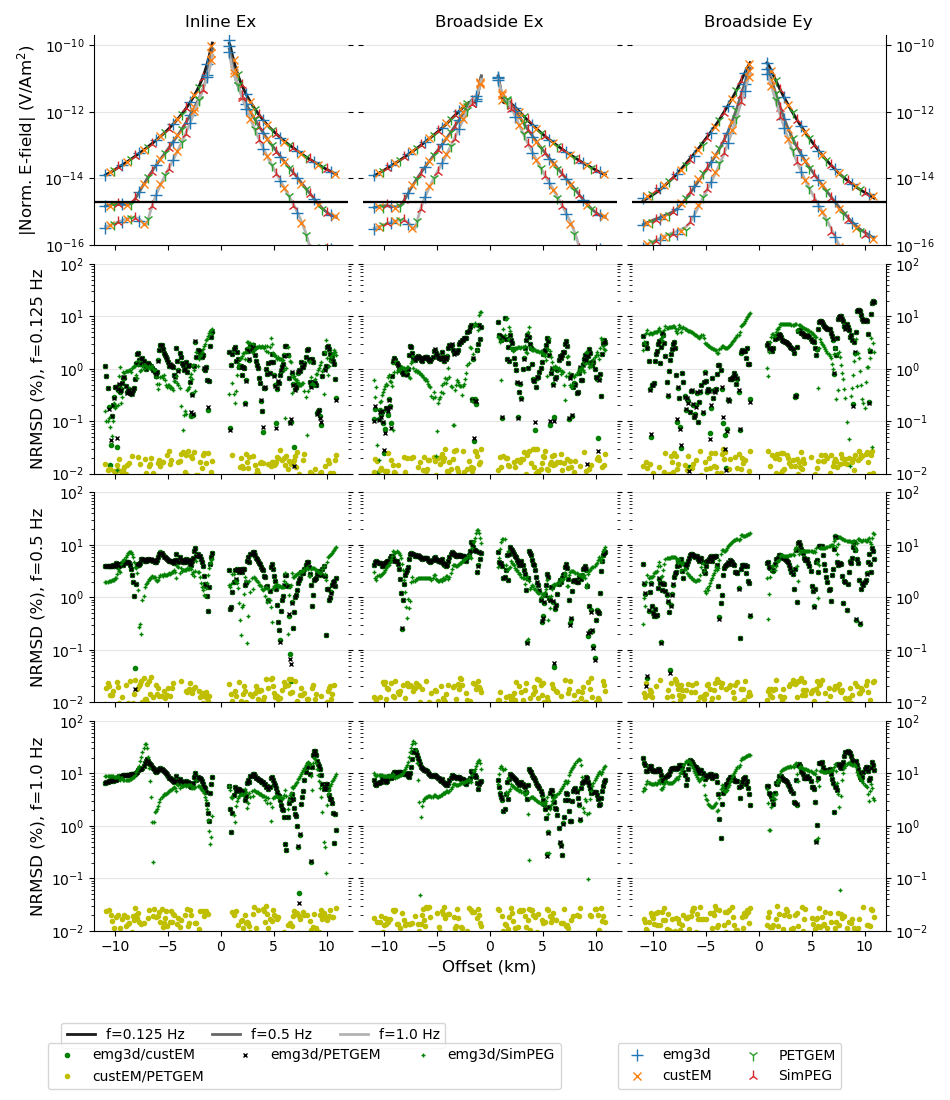

In [8]:
fs = 12
fig, axs = plt.subplots(4, 3, figsize=(9.5, 11), sharex=True)

ls = ['-', ':', '--']
ms = 8

# Loop over Inline/Broadside
for iii, datname in enumerate(['data_il', 'data_bs']):

    # Get absolute values of this line
    tdat = extract_line(data, datname)
    tegd = extract_line(egd, datname)
    tcst = extract_line(cst, datname)
    tptg = extract_line(ptg, datname)
    tspg = extract_line(spg, datname)

    # Loop over components Ex, Ey, Ez
    if datname == 'data_il':
        values = data.components.values[:1]  # Ex
    else:
        values = data.components.values[:2]  # Ex, Ey
        
    # Loop over frequencies
    for i, freq in enumerate(data.freqs.values[::2]):  # every 2nd
        
        # Fields
        for ii, comp in enumerate(values):

            plt.sca(axs[0, ii+iii])
            plt.title(f"{['Inline', 'Broadside'][iii]} {comp}")


            # Plot this component/frequency
            plt.plot(offs[:102]/1e3, tdat[:102, i*2, ii], str(.1+i*.3), lw=2,
                     label=f"f={freq} Hz" if ii+iii == 0 else None)
            plt.plot(offs[102:]/1e3, tdat[102:, i*2, ii], str(.1+i*.3), lw=2)
            
            plt.plot(offs[:102:16]/1e3, tegd[:102:16, i*2, ii], 'C0', ls="", marker="+", ms=ms,
                     label=f"emg3d" if (i == 0 and ii+iii == 1) else None)
            plt.plot(offs[102::16]/1e3, tegd[102::16, i*2, ii], 'C0', ls="", marker="+", ms=ms)
            
            plt.plot(offs[4:102:16]/1e3, tcst[4:102:16, i*2, ii], 'C1', ls="", marker="x", ms=ms-2)
            plt.plot(offs[106::16]/1e3, tcst[106::16, i*2, ii], 'C1', ls="", marker="x", ms=ms-2,
                     label=f"custEM" if (i == 0 and ii+iii == 1) else None)
            
            plt.plot(offs[8:102:16]/1e3, tptg[8:102:16, i*2, ii], 'C2', ls="", marker="1", ms=ms)
            plt.plot(offs[110::16]/1e3, tptg[110::16, i*2, ii], 'C2', ls="", marker="1", ms=ms,
                     label=f"PETGEM" if (i == 0 and ii+iii == 1) else None)
            
            plt.plot(offs[12:102:16]/1e3, tspg[12:102:16, i*2, ii], 'C3', ls="", marker="2", ms=ms)
            plt.plot(offs[114::16]/1e3, tspg[114::16, i*2, ii], 'C3', ls="", marker="2", ms=ms,
                     label=f"SimPEG" if (i == 0 and ii+iii == 1) else None)

            plt.axhline(2e-15, c='k')           
    
            plt.grid(axis='y', c='0.9')
            plt.yscale('log')
            plt.ylim([1e-16, 2e-10])
            if ii+iii == 2:
                axs[0, 2].yaxis.tick_right()
            axs[0, ii+iii].yaxis.set_ticks_position('both')

        axs[0, 0].set_ylabel('|Norm. E-field| (V/Am$^2$)', fontsize=fs)
        axs[0, 1].set_yticklabels(())

        # Error
        for ii, comp in enumerate(values):

            plt.sca(axs[1+i, ii+iii])

            # Plot difference            
            egd_cst = 200*abs(tegd[:, i*2, ii]-tcst[:, i*2, ii])/(abs(tegd[:, i*2, ii])+abs(tcst[:, i*2, ii]))
            cst_ptg = 200*abs(tcst[:, i*2, ii]-tptg[:, i*2, ii])/(abs(tcst[:, i*2, ii])+abs(tptg[:, i*2, ii]))
            egd_ptg = 200*abs(tegd[:, i*2, ii]-tptg[:, i*2, ii])/(abs(tegd[:, i*2, ii])+abs(tptg[:, i*2, ii])) 
            egd_spg = 200*abs(tegd[:, i*2, ii]-tspg[:, i*2, ii])/(abs(tegd[:, i*2, ii])+abs(tspg[:, i*2, ii]))  
                        
            plt.plot(offs/1e3, egd_cst, 'g.', label="emg3d/custEM" if i == 0 else None)
            plt.plot(offs/1e3, cst_ptg, 'y.', label="custEM/PETGEM" if i == 0 else None)
            plt.plot(offs/1e3, egd_ptg, 'kx', ms=3, label="emg3d/PETGEM" if i == 0 else None)
            plt.plot(offs/1e3, egd_spg, 'g+', ms=3, label="emg3d/SimPEG" if i == 0 else None)

            plt.grid(axis='y', c='0.9')
            plt.yscale('log')
            plt.ylim([1e-2, 1e2])
            if ii+iii == 2:
                axs[1+i, 2].yaxis.tick_right()
            axs[1+i, ii+iii].yaxis.set_ticks_position('both')

        axs[1+i, 0].set_ylabel(f'NRMSD (%), f={freq} Hz', fontsize=fs)
        axs[1+i, 1].set_yticklabels(())

    axs[3, 1].set_xlabel('Offset (km)', fontsize=fs)


# Switch off spines
for i in range(4):
    for ii in range(3):
        axs[i, ii].spines['top'].set_visible(False)
    for ii in range(2):
        axs[i, ii].spines['right'].set_visible(False)
    for ii in range(1, 3):
        axs[i, ii].spines['left'].set_visible(False)
        
plt.tight_layout(h_pad=0.02, rect=[0, 0.1, 1, 1])

plt.sca(axs[0, 1])
plt.legend(bbox_to_anchor=(0.65, 0.01), bbox_transform=fig.transFigure,
           loc='lower left', borderaxespad=0., ncol=2)  
plt.sca(axs[0, 0])
plt.legend(bbox_to_anchor=(0.05, 0.035), bbox_transform=fig.transFigure,
           loc='lower left', borderaxespad=1., ncol=3)  

plt.sca(axs[1, 0])
plt.legend(bbox_to_anchor=(0.05, 0.01), bbox_transform=fig.transFigure,
           loc='lower left', borderaxespad=0., ncol=3)  
                
#plt.savefig(f'../manuscript/figures/results-marlim_2.pdf', bbox_inches='tight')
plt.show()

In [9]:
import scooby
scooby.Report(['xarray', 'h5netcdf'])

--------------------------------------------------------------------------------
  Date: Fri Sep 11 09:00:11 2020 CEST

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 15.5 GB
       Environment : Jupyter

  Python 3.8.5 | packaged by conda-forge | (default, Aug 29 2020, 01:22:49)
  [GCC 7.5.0]

            xarray : 0.16.0
          h5netcdf : 0.8.1
             numpy : 1.19.1
             scipy : 1.5.2
           IPython : 7.18.1
        matplotlib : 3.3.1
            scooby : 0.5.6
--------------------------------------------------------------------------------